# Importación de librerías

In [1]:
import pandas as pd
import numpy as np

import os
import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Lectura del dataset

In [3]:
urbansound8k_path = "../../data/raw/UrbanSound8K/"

# Primer dataset - Carpeta con los audios
urbansound8k_audio_path = "audio/"

# Segundo dataset - Archivo CSV con metadatos sobre los audios
urbansound8k_metadata_path_file = "metadata/UrbanSound8K.csv"

# Dataset CSV con metadatos consolidados
dataset_urbansound8k_vfinal_path_file = "../../data/final/dataset_urbansound8k_vfinal.csv"


In [4]:
# Lectura
dataset_urbansound8k_df = pd.read_csv(dataset_urbansound8k_vfinal_path_file, sep=";")

dataset_urbansound8k_df.head(3)

,classID,tasa_cruce_cero,entropia_espectograma,avg_centroide_espectral,fold,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,3,1947,6.716659,2503.702337,5,-275.91843,119.49280,-98.21178,-66.515140,-42.606050,0.505066,-28.330938,-5.746867,9.992785,4.795411,15.461894,-0.069880,-2.842674
1,2,27607,9.991457,2339.221804,5,-500.90840,185.10641,-86.53282,49.858850,9.230822,22.548956,-3.567175,12.220052,7.720082,-6.460391,16.995657,-6.625116,1.469779
2,2,20971,9.728703,2070.826863,5,-531.19530,186.93994,-70.34916,40.429245,9.121047,18.398588,6.283282,15.504061,9.613501,-7.113610,16.179823,-5.710522,-0.899251


In [5]:
# Columnas disponibles del dataset
dataset_urbansound8k_df.columns

Index(['classID', 'tasa_cruce_cero', 'entropia_espectograma',
       'avg_centroide_espectral', 'fold', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13'],
      dtype='object')

# Generación datos de entrenamiento y prueba

In [7]:
# Separar las características y la variable objetivo
# ['tasa_cruce_cero', 'entropia_espectograma', 'avg_centroide_espectral'
columnas_caracteristicas = ['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
             'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']

columna_predecir = 'classID'
columna_fold = 'fold'

# Separar las características y etiquetas
X = dataset_urbansound8k_df[columnas_caracteristicas]  # Suponiendo que 'classID' es la etiqueta y 'fold' el número de fold
y = dataset_urbansound8k_df[columna_predecir]
folds = dataset_urbansound8k_df['fold']

# Modelos de Clasificacion

## KNeighborsClassifier

Fold 1 Accuracy: 0.4800
Fold 2 Accuracy: 0.3626
Fold 3 Accuracy: 0.3968
Fold 4 Accuracy: 0.3929
Fold 5 Accuracy: 0.4776
Fold 6 Accuracy: 0.4107
Fold 7 Accuracy: 0.4845
Fold 8 Accuracy: 0.4752
Fold 9 Accuracy: 0.5319
Fold 10 Accuracy: 0.4970

Accuracy promedio: 0.4509
Desviación estándar: 0.0526


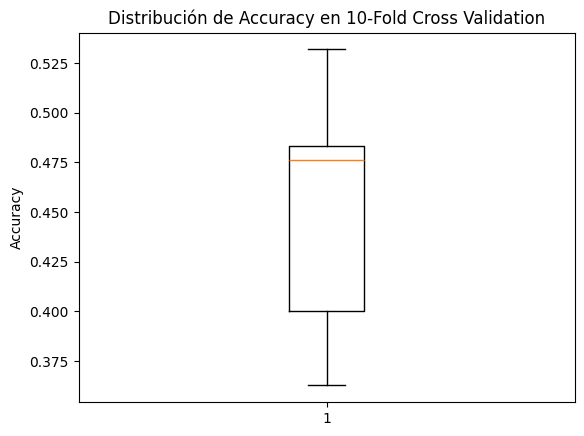

In [8]:
# Opcional: Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Configurar el modelo (SVM en este caso)
model_knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

# Inicializar lista para almacenar accuracies
fold_accuracies = []

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entrenar el modelo
    model_knn.fit(X_train, y_train)
    
    # Predecir y evaluar
    y_pred = model_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    print(f"Fold {fold} Accuracy: {accuracy:.4f}")

# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title('Distribución de Accuracy en 10-Fold Cross Validation')
plt.ylabel('Accuracy')
plt.show()


## Random Forest

Fold 1 Accuracy: 0.5212
Fold 2 Accuracy: 0.4189
Fold 3 Accuracy: 0.4530
Fold 4 Accuracy: 0.4394
Fold 5 Accuracy: 0.5513
Fold 6 Accuracy: 0.4544
Fold 7 Accuracy: 0.5477
Fold 8 Accuracy: 0.4975
Fold 9 Accuracy: 0.5417
Fold 10 Accuracy: 0.5125

Accuracy promedio: 0.4938
Desviación estándar: 0.0463


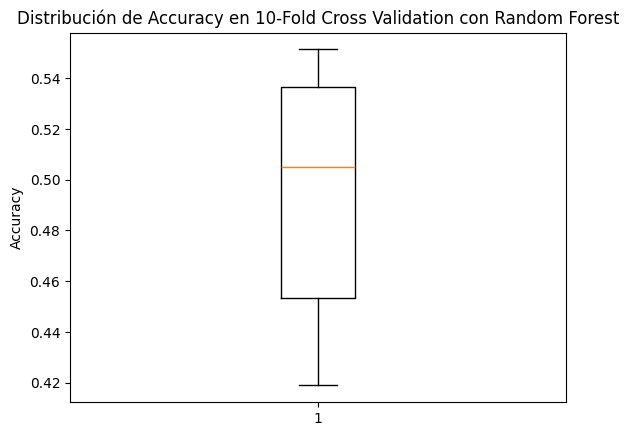

In [9]:
# Escalar los datos (opcional)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Configurar el modelo Random Forest
model_rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)  # Puedes ajustar los hiperparámetros según sea necesario

# Inicializar lista para almacenar accuracies
fold_accuracies = []

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entrenar el modelo
    model_rf.fit(X_train, y_train)
    
    # Predecir y evaluar
    y_pred = model_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    print(f"Fold {fold} Accuracy: {accuracy:.4f}")

# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title('Distribución de Accuracy en 10-Fold Cross Validation con Random Forest')
plt.ylabel('Accuracy')
plt.show()


## SVM

Fold 1 Accuracy: 0.5097
Fold 2 Accuracy: 0.3806
Fold 3 Accuracy: 0.4411
Fold 4 Accuracy: 0.4414
Fold 5 Accuracy: 0.5246
Fold 6 Accuracy: 0.4241
Fold 7 Accuracy: 0.5263
Fold 8 Accuracy: 0.5199
Fold 9 Accuracy: 0.5502
Fold 10 Accuracy: 0.5544

Accuracy promedio: 0.4872
Desviación estándar: 0.0571


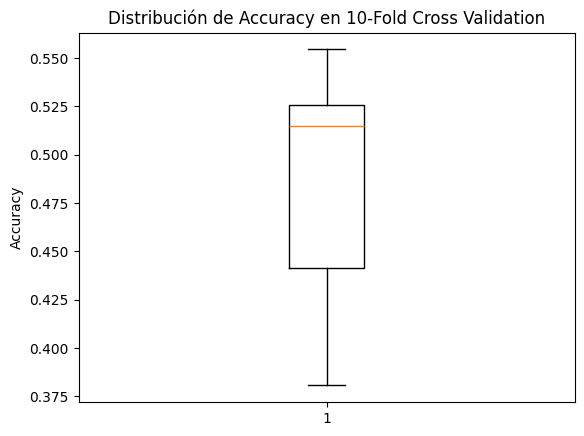

In [10]:
# Opcional: Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Configurar el modelo (SVM en este caso)
model = SVC(kernel='rbf', C=10)

# Inicializar lista para almacenar accuracies
fold_accuracies = []

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir y evaluar
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    print(f"Fold {fold} Accuracy: {accuracy:.4f}")

# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title('Distribución de Accuracy en 10-Fold Cross Validation')
plt.ylabel('Accuracy')
plt.show()
